In [1]:
import pandas as pd
from pandas.api.types import is_string_dtype
import numpy as np
from sklearn.preprocessing import LabelEncoder
import nltk
import seaborn as sns

from transformers import BertTokenizer
from transformers import TFBertModel

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import keras
from sklearn.model_selection import cross_val_score, train_test_split


from keras.layers import LSTM,  Dense, Dropout, Input, Embedding

from sklearn.metrics import classification_report


2023-05-04 00:42:18.167628: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-04 00:42:18.300917: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-04 00:42:18.301609: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 00:42:19.118584: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/arseny/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/arseny/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df = pd.read_csv('spam.csv')

EDA


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
df['label'].value_counts(normalize=True)

ham     0.865937
spam    0.134063
Name: label, dtype: float64

In [6]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

In [7]:
data = df.copy()

In [8]:
data['length'] = data.text.apply(len)
data['numb_words'] = data['text'].apply(lambda x:len(nltk.word_tokenize(x)))
data['numb_sentences'] = data['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

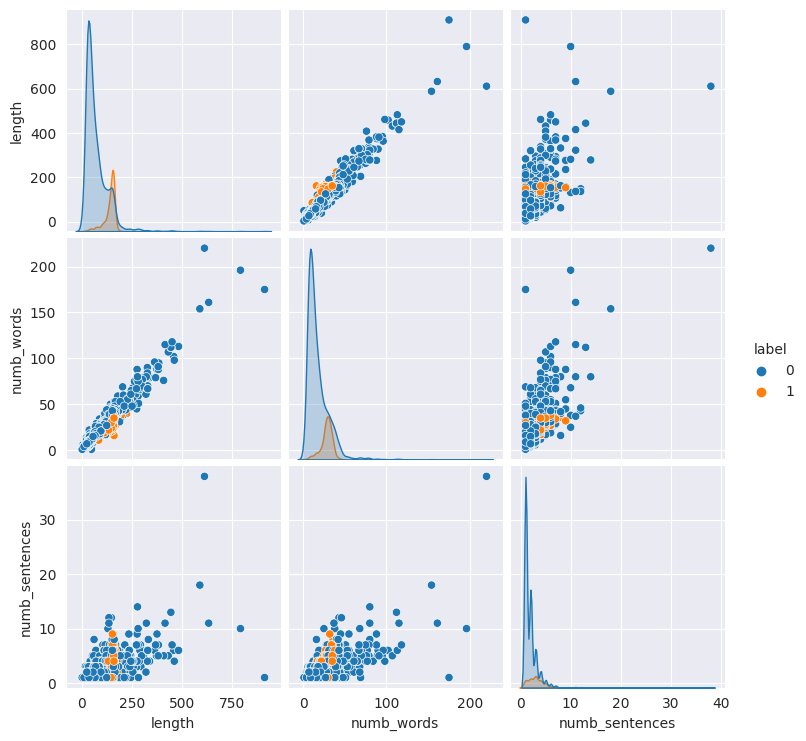

In [9]:
sns.pairplot(data,hue='label');

In [10]:
def transform_text(text):
    # Convert the text to lowercase and tokenize it
    tokens = nltk.word_tokenize(text.lower())

    # Remove non-alphanumeric tokens (%^# )
    tokens = [t for t in tokens if t.isalnum()]

    # Remove stopwords and punctuation
    stopwords_set = set(stopwords.words('english'))
    punctuation_set = set(string.punctuation)
    tokens = [token for token in tokens if token not in stopwords_set and token not in punctuation_set]

    ps = PorterStemmer()
    tokens = [ps.stem(t) for t in tokens]

    # Join the tokens back into a string and return it
    return " ".join(tokens)


In [11]:
def prepare_data(df,
                    text_df,
                    label):
    df['transformed_text'] = df[text_df].apply(transform_text)

    if is_string_dtype(df[label]):
        le = LabelEncoder()
        df[label] = le.fit_transform(df[label])
    X = df['transformed_text']
    y = df['label'].values

    return X,y


In [12]:
X,y = prepare_data(data,'text','label')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, shuffle=True)

In [14]:
X_train.shape, X_test.shape,y_train.shape,y_test.shape

((4457,), (1115,), (4457,), (1115,))


BERT

In [15]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

def bert_encode(data, maximum_length) :
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=maximum_length,
            pad_to_max_length=True,

            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids),np.array(attention_masks)

In [16]:
train_input_ids, train_attention_masks = bert_encode(X_train,60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/arseny/anaconda3/envs/5_nlp_models/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [17]:
def create_model(bert_model):

    input_ids = keras.Input(shape=(60,),dtype='int32')
    attention_masks = keras.Input(shape=(60,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = keras.layers.Dense(64,activation='relu')(output)
    output = keras.layers.Dropout(0.2)(output)
    output = keras.layers.Dense(1,activation='sigmoid')(output)

    model = keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(keras.optimizers.Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [18]:

bert_model = TFBertModel.from_pretrained('bert-base-uncased')

2023-05-04 00:42:29.945878: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use 

In [19]:
model = create_model(bert_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 60,                                            

/home/arseny/anaconda3/envs/5_nlp_models/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [20]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    y_train,
    validation_split=0.15,
    epochs=3,
    batch_size=10
)

Epoch 1/3
379/379 [==============================] - 630s 2s/step - loss: 0.1141 - accuracy: 0.9641 - val_loss: 0.0677 - val_accuracy: 0.9836
Epoch 2/3
379/379 [==============================] - 616s 2s/step - loss: 0.0501 - accuracy: 0.9857 - val_loss: 0.0316 - val_accuracy: 0.9910
Epoch 3/3
379/379 [==============================] - 623s 2s/step - loss: 0.0259 - accuracy: 0.9950 - val_loss: 0.0445 - val_accuracy: 0.9865


In [21]:
test_input_ids, test_attention_masks = bert_encode(X_test,60)

In [22]:
pred = model.predict([test_input_ids, test_attention_masks])

35/35 [==============================] - 45s 1s/step


In [23]:
# Check the model performance
print(classification_report(y_test, pred.round()))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       955
           1       0.99      0.89      0.94       160

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [24]:
model.save_weights('bert_weights.h5')